In [1]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Activation
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import sklearn.metrics as metrics
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#111111', '#222222', '#333333', '#444444', '#555555', '#666666', '#777777', '#888888']
    markers = ['o', 's', 'o', 's','o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [3]:
def run_sampler( X, y, sampler ) :
    print(X.shape)
    print(y.shape)

    X_samples, _, _, _ = X.shape

    d2_X = X.reshape((X_samples,config.buckets*config.max_len*channels))

    X_s, y_s = sampler.fit_sample(d2_X, y)

    #plot_2d_space(X_rus, y_rus, 'Random under-sampling')

    X_s = X_s.reshape((X_s.shape[0], config.buckets, config.max_len, channels))
    print("X_s", X_s.shape)
    print("Y_s", y_s.shape)
    
    return X_s, y_s

In [4]:
hyperparameter_defaults = dict(
    max_len = 30,
    buckets = 118,
    epochs = 3,
    batch_size = 84,
    layer_one = 109,
    layer_two = 81,
    layer_three = 104,
    layer_four = 118,
    dropout_one = 0.2761,
    dropout_two = 0.2757,
    sampler = 'over'
    )

wandb.init( config=hyperparameter_defaults )
config = wandb.config

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', '91f9828cb2956a779f4f3c6e9f9cd9301f7c5a7f']' timed out after 5 seconds


In [5]:
# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=np.array(["GOC", "GRA", "GST", 
                 "GWG", "GWC", "OPI", "OQU"])

# Loading train/test set
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test()
print(X_train[0])
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1

# Number of classes
num_classes = labels.shape[0]
print(X_train.shape)

# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

Saving vectors of label - 'OQU': 100%|█████████████████████████████████████████████| 2151/2151 [00:32<00:00, 66.31it/s]


[[-0.26908916 -0.21215466 -0.25417376 ... -0.12273278 -0.13290174
   0.        ]
 [ 0.18214501  0.18704809  0.1840616  ...  0.18790656  0.1909574
   0.        ]
 [-0.16044778 -0.16843191 -0.17172892 ... -0.19189033 -0.18943985
   0.        ]
 ...
 [-0.14400516 -0.11071743  0.35820666 ...  0.11894916  0.2222774
   0.        ]
 [ 0.00222387  0.02916489 -0.00823778 ...  0.09200083  0.00151309
   0.        ]
 [ 0.09008241 -0.0207413  -0.05242233 ...  0.2506018   0.10936624
   0.        ]]
(1946, 118, 30)


In [6]:
under_sampler = RandomUnderSampler()
over_sampler = RandomOverSampler()
smote_sampler = SMOTETomek()

if(config.sampler == 'under') :
    sampler = under_sampler
    X_train, y_train = run_sampler( X_train, y_train, sampler )
    X_test, y_test = run_sampler( X_test, y_test, sampler )
    X_val, y_val = run_sampler( X_val, y_val, sampler )
    
if(config.sampler == 'over') :
    sampler = over_sampler
    X_train, y_train = run_sampler( X_train, y_train, sampler )
    X_test, y_test = run_sampler( X_test, y_test, sampler )
    X_val, y_val = run_sampler( X_val, y_val, sampler )
    
if(config.sampler == 'smote') :
    sampler = smote_sampler
    X_train, y_train = run_sampler( X_train, y_train, sampler )
    X_test, y_test = run_sampler( X_test, y_test, sampler )
    X_val, y_val = run_sampler( X_val, y_val, sampler )

(1946, 118, 30, 1)
(1946,)
X_s (7210, 118, 30, 1)
Y_s (7210,)
(812, 118, 30, 1)
(812,)
X_s (2898, 118, 30, 1)
Y_s (2898,)
(1298, 118, 30, 1)
(1298,)
X_s (4949, 118, 30, 1)
Y_s (4949,)


(7210, 118, 30, 1)


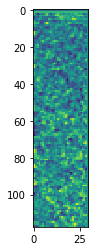

In [7]:
# Spectrogram visualized of 0th element
print(X_train.shape)
plt.imshow(X_train[200, :, :, 0])

In [8]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [9]:

# Building the model
model = Sequential()

input_shape= (config.buckets, config.max_len, channels)

model.add(Conv2D( config.layer_one, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D( config.layer_two, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D( config.layer_three, (3, 1), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=config.dropout_one))

model.add(Dense( config.layer_four ))
model.add(Activation('relu'))
model.add(Dropout(rate=config.dropout_two))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 28, 109)      1090      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 14, 109)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 58, 14, 109)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 12, 81)        79542     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 6, 81)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 28, 6, 81)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 6, 104)      

In [10]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [11]:
wandb.init()
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', '91f9828cb2956a779f4f3c6e9f9cd9301f7c5a7f']' timed out after 5 seconds



Train on 7210 samples, validate on 4949 samples
Epoch 1/3


5952/7210 [=======================>......] - ETA: 12:16 - loss: 1.9449 - accuracy: 0.125 - ETA: 8:37 - loss: 1.9911 - accuracy: 0.140 - ETA: 7:14 - loss: 1.9733 - accuracy: 0.16 - ETA: 6:46 - loss: 1.9705 - accuracy: 0.17 - ETA: 6:24 - loss: 1.9617 - accuracy: 0.18 - ETA: 6:03 - loss: 1.9641 - accuracy: 0.17 - ETA: 5:52 - loss: 1.9622 - accuracy: 0.16 - ETA: 5:42 - loss: 1.9601 - accuracy: 0.16 - ETA: 5:31 - loss: 1.9593 - accuracy: 0.17 - ETA: 5:24 - loss: 1.9625 - accuracy: 0.16 - ETA: 5:09 - loss: 1.9606 - accuracy: 0.16 - ETA: 5:01 - loss: 1.9599 - accuracy: 0.16 - ETA: 4:49 - loss: 1.9580 - accuracy: 0.17 - ETA: 4:43 - loss: 1.9571 - accuracy: 0.17 - ETA: 4:35 - loss: 1.9560 - accuracy: 0.17 - ETA: 4:30 - loss: 1.9554 - accuracy: 0.16 - ETA: 4:25 - loss: 1.9547 - accuracy: 0.16 - ETA: 4:21 - loss: 1.9532 - accuracy: 0.16 - ETA: 4:16 - loss: 1.9510 - accuracy: 0.16 - ETA: 4:14 - loss: 1.9503 - accuracy: 0.16 - ETA: 4:11 - loss: 1.9490 - accuracy: 0.16 - ETA: 4:08 - loss: 1.9494 - a

7210/7210 [==============================] - ETA: 36s - loss: 1.1845 - accuracy: 0.549 - ETA: 35s - loss: 1.1823 - accuracy: 0.549 - ETA: 34s - loss: 1.1790 - accuracy: 0.551 - ETA: 33s - loss: 1.1757 - accuracy: 0.552 - ETA: 32s - loss: 1.1729 - accuracy: 0.553 - ETA: 31s - loss: 1.1694 - accuracy: 0.554 - ETA: 31s - loss: 1.1661 - accuracy: 0.555 - ETA: 30s - loss: 1.1634 - accuracy: 0.556 - ETA: 29s - loss: 1.1599 - accuracy: 0.557 - ETA: 28s - loss: 1.1563 - accuracy: 0.559 - ETA: 27s - loss: 1.1530 - accuracy: 0.560 - ETA: 26s - loss: 1.1495 - accuracy: 0.561 - ETA: 25s - loss: 1.1471 - accuracy: 0.562 - ETA: 24s - loss: 1.1458 - accuracy: 0.562 - ETA: 23s - loss: 1.1435 - accuracy: 0.563 - ETA: 22s - loss: 1.1407 - accuracy: 0.564 - ETA: 21s - loss: 1.1373 - accuracy: 0.566 - ETA: 20s - loss: 1.1345 - accuracy: 0.567 - ETA: 19s - loss: 1.1311 - accuracy: 0.568 - ETA: 18s - loss: 1.1290 - accuracy: 0.568 - ETA: 17s - loss: 1.1259 - accuracy: 0.570 - ETA: 16s - loss: 1.1230 - accur

5952/7210 [=======================>......] - ETA: 3:37 - loss: 0.3497 - accuracy: 0.84 - ETA: 3:33 - loss: 0.3653 - accuracy: 0.85 - ETA: 3:27 - loss: 0.3506 - accuracy: 0.88 - ETA: 3:27 - loss: 0.4339 - accuracy: 0.85 - ETA: 3:23 - loss: 0.4041 - accuracy: 0.85 - ETA: 3:24 - loss: 0.4113 - accuracy: 0.84 - ETA: 3:24 - loss: 0.4206 - accuracy: 0.85 - ETA: 3:23 - loss: 0.4572 - accuracy: 0.84 - ETA: 3:23 - loss: 0.4581 - accuracy: 0.84 - ETA: 3:23 - loss: 0.4412 - accuracy: 0.85 - ETA: 3:22 - loss: 0.4628 - accuracy: 0.83 - ETA: 3:22 - loss: 0.4625 - accuracy: 0.83 - ETA: 3:19 - loss: 0.4556 - accuracy: 0.84 - ETA: 3:18 - loss: 0.4806 - accuracy: 0.82 - ETA: 3:16 - loss: 0.4890 - accuracy: 0.82 - ETA: 3:17 - loss: 0.4825 - accuracy: 0.82 - ETA: 3:15 - loss: 0.4814 - accuracy: 0.82 - ETA: 3:15 - loss: 0.4789 - accuracy: 0.82 - ETA: 3:14 - loss: 0.4757 - accuracy: 0.83 - ETA: 3:13 - loss: 0.4756 - accuracy: 0.83 - ETA: 3:13 - loss: 0.4850 - accuracy: 0.82 - ETA: 3:12 - loss: 0.4784 - accu

7210/7210 [==============================] - ETA: 37s - loss: 0.3638 - accuracy: 0.871 - ETA: 36s - loss: 0.3628 - accuracy: 0.871 - ETA: 35s - loss: 0.3622 - accuracy: 0.872 - ETA: 34s - loss: 0.3614 - accuracy: 0.872 - ETA: 33s - loss: 0.3607 - accuracy: 0.872 - ETA: 32s - loss: 0.3597 - accuracy: 0.872 - ETA: 31s - loss: 0.3606 - accuracy: 0.871 - ETA: 30s - loss: 0.3598 - accuracy: 0.872 - ETA: 29s - loss: 0.3590 - accuracy: 0.872 - ETA: 28s - loss: 0.3581 - accuracy: 0.872 - ETA: 27s - loss: 0.3583 - accuracy: 0.872 - ETA: 26s - loss: 0.3578 - accuracy: 0.872 - ETA: 25s - loss: 0.3568 - accuracy: 0.872 - ETA: 24s - loss: 0.3569 - accuracy: 0.872 - ETA: 23s - loss: 0.3561 - accuracy: 0.873 - ETA: 22s - loss: 0.3558 - accuracy: 0.873 - ETA: 21s - loss: 0.3549 - accuracy: 0.873 - ETA: 20s - loss: 0.3537 - accuracy: 0.873 - ETA: 19s - loss: 0.3535 - accuracy: 0.873 - ETA: 18s - loss: 0.3534 - accuracy: 0.873 - ETA: 17s - loss: 0.3552 - accuracy: 0.873 - ETA: 16s - loss: 0.3549 - accur

5952/7210 [=======================>......] - ETA: 3:26 - loss: 0.1679 - accuracy: 0.93 - ETA: 3:21 - loss: 0.1845 - accuracy: 0.93 - ETA: 3:18 - loss: 0.1644 - accuracy: 0.93 - ETA: 3:19 - loss: 0.1844 - accuracy: 0.93 - ETA: 3:14 - loss: 0.2114 - accuracy: 0.93 - ETA: 3:20 - loss: 0.1992 - accuracy: 0.93 - ETA: 3:17 - loss: 0.2079 - accuracy: 0.93 - ETA: 3:17 - loss: 0.2202 - accuracy: 0.92 - ETA: 3:17 - loss: 0.2095 - accuracy: 0.93 - ETA: 3:22 - loss: 0.2069 - accuracy: 0.93 - ETA: 3:20 - loss: 0.2043 - accuracy: 0.92 - ETA: 3:19 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:19 - loss: 0.2180 - accuracy: 0.92 - ETA: 3:18 - loss: 0.2118 - accuracy: 0.92 - ETA: 3:18 - loss: 0.2046 - accuracy: 0.93 - ETA: 3:17 - loss: 0.2046 - accuracy: 0.93 - ETA: 3:15 - loss: 0.2065 - accuracy: 0.93 - ETA: 3:22 - loss: 0.2010 - accuracy: 0.93 - ETA: 3:24 - loss: 0.1976 - accuracy: 0.93 - ETA: 3:25 - loss: 0.1999 - accuracy: 0.93 - ETA: 3:27 - loss: 0.1972 - accuracy: 0.93 - ETA: 3:26 - loss: 0.1967 - accu

7210/7210 [==============================] - ETA: 36s - loss: 0.1801 - accuracy: 0.933 - ETA: 36s - loss: 0.1800 - accuracy: 0.932 - ETA: 35s - loss: 0.1804 - accuracy: 0.933 - ETA: 34s - loss: 0.1800 - accuracy: 0.933 - ETA: 33s - loss: 0.1801 - accuracy: 0.933 - ETA: 32s - loss: 0.1804 - accuracy: 0.933 - ETA: 31s - loss: 0.1803 - accuracy: 0.933 - ETA: 30s - loss: 0.1810 - accuracy: 0.933 - ETA: 29s - loss: 0.1805 - accuracy: 0.933 - ETA: 28s - loss: 0.1805 - accuracy: 0.933 - ETA: 27s - loss: 0.1812 - accuracy: 0.932 - ETA: 26s - loss: 0.1807 - accuracy: 0.933 - ETA: 25s - loss: 0.1805 - accuracy: 0.933 - ETA: 24s - loss: 0.1803 - accuracy: 0.933 - ETA: 23s - loss: 0.1804 - accuracy: 0.933 - ETA: 22s - loss: 0.1799 - accuracy: 0.933 - ETA: 21s - loss: 0.1792 - accuracy: 0.934 - ETA: 20s - loss: 0.1799 - accuracy: 0.933 - ETA: 19s - loss: 0.1796 - accuracy: 0.933 - ETA: 18s - loss: 0.1792 - accuracy: 0.933 - ETA: 17s - loss: 0.1790 - accuracy: 0.933 - ETA: 16s - loss: 0.1786 - accur

In [12]:
# Save the keras model
model.save("bio_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [14]:
from keras.models import load_model

# Load the model
loaded_model = load_model('bio_cnn_model.h5')

In [15]:
# Summarize the model
model.summary()
from keras.utils.vis_utils import plot_model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 28, 109)      1090      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 14, 109)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 58, 14, 109)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 12, 81)        79542     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 6, 81)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 28, 6, 81)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 6, 104)       

[[376   0   0  12   0   0  26]
 [  2 212   3  60  14  29  94]
 [  0 135  43  43   0  34 159]
 [ 26  35   9 189  17  36 102]
 [  7   6  11  58  81   0 251]
 [  0  64   0  45  27 125 153]
 [  5  29   1  34   3  16 326]]
Accuracy for class GOC : [0.90821256]
Accuracy for class GRA : [0.51207729]
Accuracy for class GST : [0.10386473]
Accuracy for class GWG : [0.45652174]
Accuracy for class GWC : [0.19565217]
Accuracy for class OPI : [0.30193237]
Accuracy for class OQU : [0.78743961]
Overall Accuracy : 0.4665286404416839
Average Accuracy


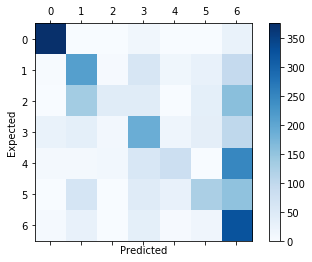

'[[ 24   0   0   0   0   0  10]\n [  1   4   0   0   0   0   3]\n [  0   0   5   0   0   0  16]\n [  2   0   0   0   0   0   1]\n [  0   0   0   0   0   0   6]\n [  0   0   0   0   0   2   3]\n [  1   0   1   1   0   0 194]]\nAccuracy for class AAT : [0.70588235]\nAccuracy for class AHV : [0.5]\nAccuracy for class AMA : [0.23809524]\nAccuracy for class ART : [0.]\nAccuracy for class ASI : [0.]\nAccuracy for class AVH : [0.4]\nAccuracy for class AVT : [0.98477157]\nOverall Accuracy : 0.8357664233576643'

In [16]:
y_pred_ohe = loaded_model.predict(X_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape
print(confusion_matrix)
sum_avg = 0
for class_i in range(len(labels)) :
    indices = np.argwhere(y_test == class_i)
    sum = 0
    for index in indices:
        sum += (y_test[index] == y_pred_labels[index])
    if(len(indices) > 0) : mean = sum/len(indices)
    else : mean = "N/A"
    sum_avg += mean
    print("Accuracy for class", labels[class_i], ":", mean)
avg_mean = sum / len(labels)
    
print("Overall Accuracy :", np.mean(y_test == y_pred_labels))
print("Average Accuracy")

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

'''[[ 24   0   0   0   0   0  10]
 [  1   4   0   0   0   0   3]
 [  0   0   5   0   0   0  16]
 [  2   0   0   0   0   0   1]
 [  0   0   0   0   0   0   6]
 [  0   0   0   0   0   2   3]
 [  1   0   1   1   0   0 194]]
Accuracy for class AAT : [0.70588235]
Accuracy for class AHV : [0.5]
Accuracy for class AMA : [0.23809524]
Accuracy for class ART : [0.]
Accuracy for class ASI : [0.]
Accuracy for class AVH : [0.4]
Accuracy for class AVT : [0.98477157]
Overall Accuracy : 0.8357664233576643'''

In [17]:
from sklearn.metrics import classification_report, zero_one_loss

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

zero1loss = zero_one_loss(y_true=y_test, y_pred=y_pred_labels)

2898/2898 [==============================] - ETA: 38 - ETA: 35 - ETA: 38 - ETA: 37 - ETA: 58 - ETA: 54 - ETA: 58 - ETA: 54 - ETA: 51 - ETA: 47 - ETA: 44 - ETA: 42 - ETA: 39 - ETA: 38 - ETA: 36 - ETA: 34 - ETA: 32 - ETA: 31 - ETA: 29 - ETA: 28 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 45s 15ms/step


In [18]:
print(classification_report(y_test, y_pred_bool))
print(zero1loss)

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       414
         1.0       0.44      0.51      0.47       414
         2.0       0.64      0.10      0.18       414
         3.0       0.43      0.46      0.44       414
         4.0       0.57      0.20      0.29       414
         5.0       0.52      0.30      0.38       414
         6.0       0.29      0.79      0.43       414

    accuracy                           0.47      2898
   macro avg       0.54      0.47      0.44      2898
weighted avg       0.54      0.47      0.44      2898

0.533471359558316


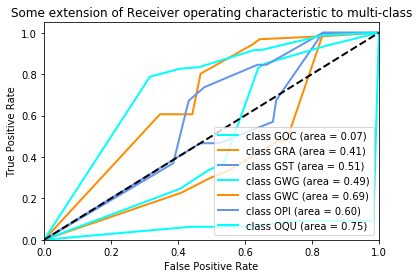

In [19]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_labels, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_labels.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
## Running the model

n_mfcc = config.buckets
max_len = config.max_len
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    #prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


FileNotFoundError: [Errno 2] No such file or directory: './prediction/nature_sc.wav'